In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
data, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'])
#Here with info are the labels... and the required information like length
(train_data, validation_data, test_data) = data

In [3]:
total_examp = info.splits['train'].num_examples
description = info.description
total_class = info.features['label'].num_classes
labels = info.features['label'].num_classes

print(total_examp)
print(description)
print(total_class)
print(labels)

60000
Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
10
10


In [4]:
#We only know the num of classes so to get the columns we will assign them
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [5]:
infile = open('labels.txt', 'w')
infile.write('\n'.join(class_names))

75

In [6]:
IMG_SIZE = 28
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

In [7]:
#Mapping the format of images
BATCH_SIZE = 32
train_batch = train_data.cache().shuffle(total_examp//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
valid_batch = validation_data.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batch = test_data.cache().map(format_image).batch(1)

In [8]:
#Making the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16 ,3, activation = 'relu', input_shape = (IMG_SIZE, IMG_SIZE, 1)))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32, 3, activation = 'relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 10))
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
__________________________________________________

In [9]:
#Fitting the model
history = model.fit(train_batch, epochs=15, validation_data=valid_batch)

Epoch 1/15
1500/1500 [==============================] - 25s 16ms/step - loss: 0.4605 - accuracy: 0.8371 - val_loss: 0.3289 - val_accuracy: 0.8757
Epoch 2/15
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3088 - accuracy: 0.8892 - val_loss: 0.2855 - val_accuracy: 0.8940
Epoch 3/15
1500/1500 [==============================] - 22s 14ms/step - loss: 0.2609 - accuracy: 0.9046 - val_loss: 0.2563 - val_accuracy: 0.9042
Epoch 4/15
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2252 - accuracy: 0.9172 - val_loss: 0.2312 - val_accuracy: 0.9122
Epoch 5/15
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1942 - accuracy: 0.9278 - val_loss: 0.2613 - val_accuracy: 0.9020
Epoch 6/15
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1716 - accuracy: 0.9367 - val_loss: 0.2445 - val_accuracy: 0.9127
Epoch 7/15
1500/1500 [==============================] - 24s 16ms/step - loss: 0.1465 - accuracy: 0.9456 - val_loss: 0.2532 -

In [10]:
hist = history.history
columns = hist.keys()
epochs = history.epoch
print(columns)
print(hist['loss'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.460492342710495, 0.3088129460811615, 0.2608567178249359, 0.22519437968730927, 0.19422540068626404, 0.17155922949314117, 0.1465226709842682, 0.12844718992710114, 0.11145150661468506, 0.09617459774017334, 0.08379966020584106, 0.07028378546237946, 0.06344901025295258, 0.053402625024318695, 0.04724545404314995]


Text(0, 0.5, 'Epochs')

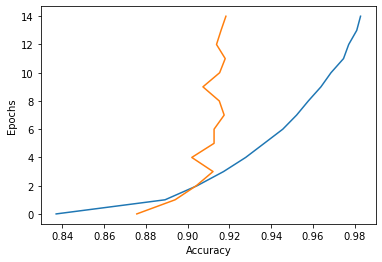

In [11]:
#Plotting the graph
plt.plot(hist['accuracy'], epochs, label='Accuracy')
plt.plot(hist['val_accuracy'], epochs, label='val_accuracy')
plt.xlabel("Accuracy")
plt.ylabel("Epochs")

In [12]:
export_model = 'tfJS_fashion/1'
tf.saved_model.save(model,export_model)

INFO:tensorflow:Assets written to: tfJS_fashion/1\assets


INFO:tensorflow:Assets written to: tfJS_fashion/1\assets


In [13]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [14]:
tflite_model_file = 'model.tflite'
infil = open(tflite_model_file, "wb")
infil.write(tflite_model)

259600

# Test the model with TFLite interpreter

In [15]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input = interpreter.get_input_details()[0]['index']
input1 = interpreter.get_input_details()
output = interpreter.get_output_details()[0]['index']
print(input1)

[{'name': 'serving_default_conv2d_input:0', 'index': 0, 'shape': array([ 1, 28, 28,  1]), 'shape_signature': array([-1, 28, 28,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [16]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for image, label in test_batch.take(20):
    interpreter.set_tensor(input, image)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output))
    test_labels.append(label[0])
    test_images.append(np.array(image))

test_labels[0].numpy()
predictions[0]

array([[-11.287231  , -17.363602  , -15.306795  , -17.051914  ,
         -9.85257   ,  17.295372  ,  -7.346591  ,   0.05900886,
         -2.928459  , -17.636473  ]], dtype=float32)

In [17]:

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
  
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label.numpy():
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)), class_names, rotation='vertical')
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

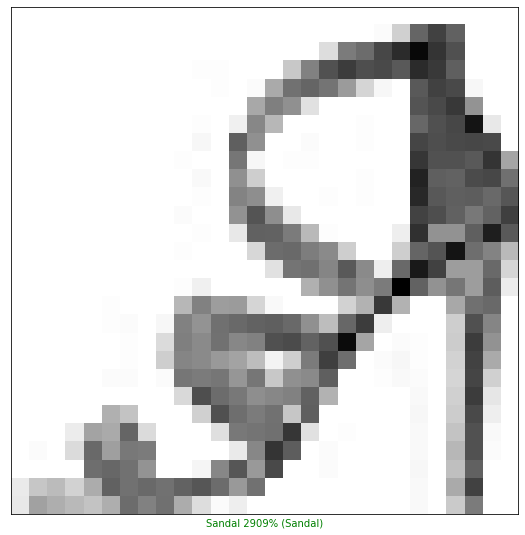

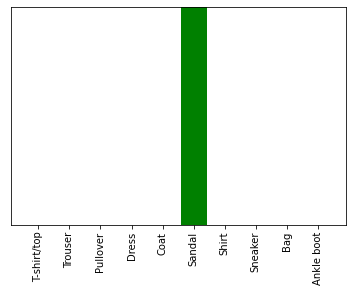

In [18]:
index = 19
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()